In [129]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull


In [ ]:
def griewank(X):
    X = np.asarray(X)
    j = np.sqrt(np.arange(1, 4))  # [1, 2, 3] -> sqrt
    term1 = np.sum(X**2, axis=-1) / 4000
    term2 = np.prod(np.cos(X / j), axis=-1)
    return term1 - term2 + 1

def ackley(X):
    X = np.asarray(X)
    d = X.shape[-1]
    sum_sq = np.sum(X**2, axis=-1)
    cos_sum = np.sum(np.cos(2 * np.pi * X), axis=-1)
    return -20 * np.exp(-0.2 * np.sqrt(sum_sq / d)) - np.exp(cos_sum / d) + 20 + np.e

def rastrigin(X):
    X = np.asarray(X)
    A = 10
    D = X.shape[-1]  # dimensionality (should be 3)
    return A * D + np.sum(X**2 - A * np.cos(2 * np.pi * X), axis=-1)

def rosenbrock(X):
    X = np.asarray(X)
    return np.sum(100 * (X[..., 1:] - X[..., :-1]**2)**2 + (1 - X[..., :-1])**2, axis=-1)

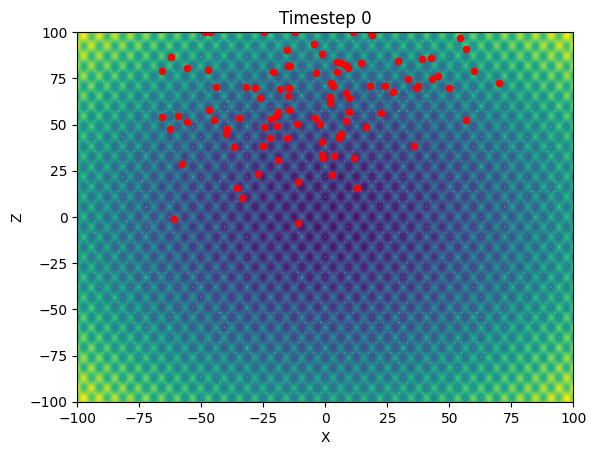

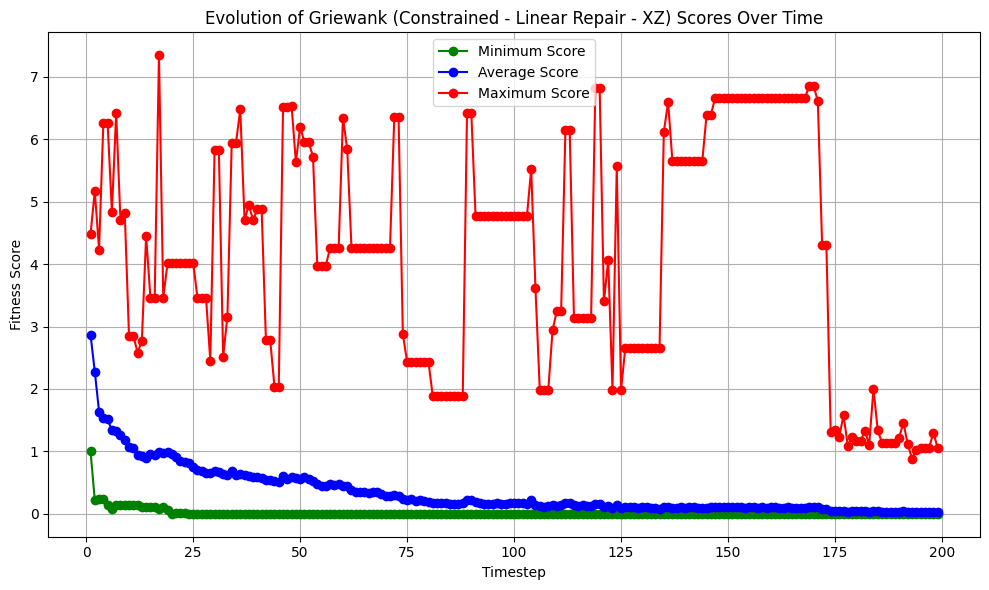

In [179]:
load_and_plot("pso_griewank.npy", griewank, "Griewank (Constrained - Linear Repair - XZ)", 1, 200, 10)

In [ ]:
def load_and_plot(file_loc, objective, name, min_t, max_t, fps=10):
    # plot_objective(objective, name)

    data = np.load(file_loc)
    positions_og = data["positions"]
    # velocities = data["velocities"]
    scores = data["scores"]

    plot_particle_movement(positions_og, min_t, max_t, name, objective, fps)
    plot_scores(scores, min_t, max_t, name)


def plot_objective(objective, name):
    x = np.linspace(-100, 100, 1000)
    y = np.linspace(-100, 100, 1000)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Stack into (n_points, 3)
    points = np.stack([X, Y, Z], axis=-1)

    # Evaluate Griewank
    F = objective(points)

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, F, cmap='viridis', alpha=0.8, edgecolor='none')
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.set_zlabel(f"{name}(x₁, x₂, 0)")
    ax.set_title(f"{name} Function Slice (x₃ = 0)")

    plt.tight_layout()
    # plt.show()

    plt.savefig(f"{name}_slice.png")

def plot_particle_movement(positions_og, min_t, max_t, name, objective, fps):
    # Trim positions to desired frame range
    positions = positions_og[min_t:max_t, :, :]

    # Setup 2D plot
    fig, ax = plt.subplots()

    # Generate a grid over the XZ plane
    x = np.linspace(-100, 100, 300)
    z = np.linspace(-100, 100, 300)
    X_grid, Z_grid = np.meshgrid(x, z)

    # Create (N, 3) input with Y fixed at 0
    points = np.stack([X_grid, np.zeros_like(X_grid), Z_grid], axis=-1)
    F = objective(points)

    # Plot contours or heatmap
    contour = ax.contourf(X_grid, Z_grid, F, levels=100, cmap='viridis', alpha=0.7)

    # Initial scatter plot for particles
    scat = ax.scatter([], [], color='red', s=20)

    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_title("Timestep 0")

    # Animation update function
    def update(frame):
        pos = positions[frame]
        xz = np.stack([pos[:, 0], pos[:, 2]], axis=-1)  # X and Z
        scat.set_offsets(xz)
        ax.set_title(f"Timestep {frame}")
        return scat,

    # Create animation
    anim = FuncAnimation(fig, update, frames=range(positions.shape[0]), interval=50)

    # Save as GIF
    anim.save(f"particle_motion_with_{name}.gif", writer=PillowWriter(fps=fps))

def plot_scores(scores, min_t, max_t, name):
        # Trim scores to match the animation range
    min_scores = np.min(scores, axis=1)[min_t:max_t]
    max_scores = np.max(scores, axis=1)[min_t:max_t]
    average_scores = np.mean(scores, axis=1)[min_t:max_t]
    timesteps = np.arange(min_t, max_t)

    # Create static scatter plot
    plt.figure(figsize=(10, 6))

    plt.plot(timesteps, min_scores, 'o-', label='Minimum Score', color='green')
    plt.plot(timesteps, average_scores, 'o-', label='Average Score', color='blue')
    plt.plot(timesteps, max_scores, 'o-', label='Maximum Score', color='red')

    plt.xlabel('Timestep')
    plt.ylabel('Fitness Score')
    plt.title(f'Evolution of {name} Scores Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{name}_scores.png', dpi=150)

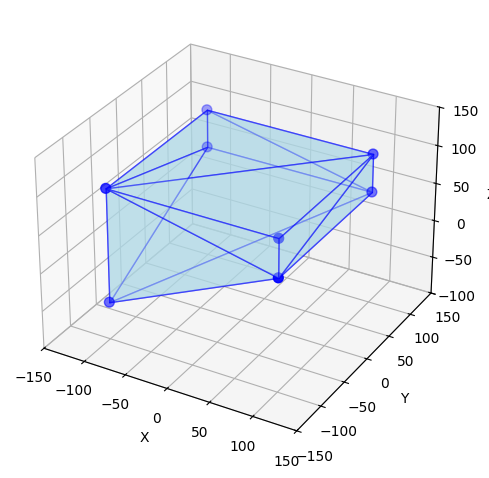

In [160]:
# Define the 8 custom vertices manually
points = np.load("verts.npy")
# Compute the convex hull
hull = ConvexHull(points)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the vertices
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', s=50)

# Plot the convex hull faces
for simplex in hull.simplices:
    face = points[simplex]
    poly = Poly3DCollection([face], alpha=0.5, facecolor='lightblue', edgecolor='blue')
    ax.add_collection3d(poly)

# Set plot limits
ax.set_xlim([-150, 150])
ax.set_ylim([-150, 150])
ax.set_zlim([-100, 150])

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [167]:
points.shape

(10000, 3)

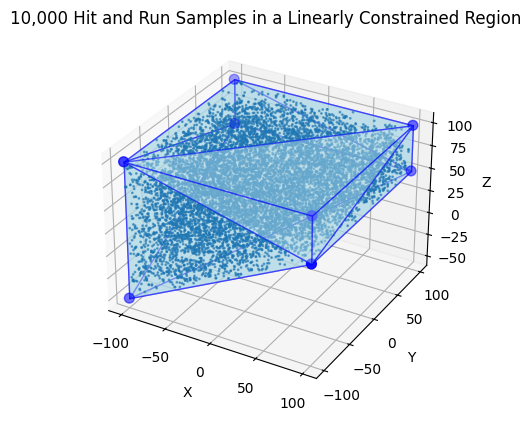

In [184]:
# Define the 8 custom vertices manually
points = np.load("verts.npy")
# Compute the convex hull
hull = ConvexHull(points)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the vertices
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', s=50)

# Plot the convex hull faces
for simplex in hull.simplices:
    face = points[simplex]
    poly = Poly3DCollection([face], alpha=0.5, facecolor='lightblue', edgecolor='blue')
    ax.add_collection3d(poly)

# Scatter plot using the 3 columns as x, y, z
samples = np.load("sample.npy")
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], s=1, alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("10,000 Hit and Run Samples in a Linearly Constrained Region")
# plt.show()
plt.savefig("hit_and_run_samples.png")